In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('data/Womens Clothing E-Commerce Reviews.csv').drop('Unnamed: 0', axis=1)

In [3]:
data.head()

Clothing ID  Age                    Title  \
0          767   33                      NaN   
1         1080   34                      NaN   
2         1077   60  Some major design flaws   
3         1049   50         My favorite buy!   
4          847   47         Flattering shirt   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   

   Positive Feedback Count   Division Name Department Name Class Name  
0                        0       Initmates        Intimate  Intimates  
1                        4         General         Dresses    Dresses  
2                        0         General         Dresses    Dresses  
3                        0  General Petite         Bottoms      Pants  
4                        6         General            Tops    Blouses

In [4]:
data.shape

(23486, 10)

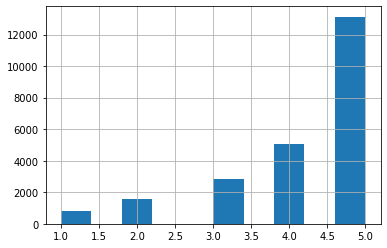

In [5]:
data.Rating.hist() # most of the ratings are high

In [6]:
doc_rating = data[['Review Text', 'Rating', 'Age', 'Positive Feedback Count']]

In [7]:
doc_rating.head()

Review Text  Rating  Age  \
0  Absolutely wonderful - silky and sexy and comf...       4   33   
1  Love this dress!  it's sooo pretty.  i happene...       5   34   
2  I had such high hopes for this dress and reall...       3   60   
3  I love, love, love this jumpsuit. it's fun, fl...       5   50   
4  This shirt is very flattering to all due to th...       5   47   

   Positive Feedback Count  
0                        0  
1                        4  
2                        0  
3                        0  
4                        6

# Predict Rating using review Text

In [8]:
# !pip install gensim
# !pip install pyLDAvis
# nltk.download('stopwords')
# nltk.download('wordnet')
import nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

import gensim
from gensim import corpora
from gensim.models import CoherenceModel

# Plotting tools

import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized


### Cleaning and Preprocessing
Remove the punctuations, stopwords and normalize the corpus.

In [10]:
doc_rating['clean_doc'] = doc_rating['Review Text'].astype(str).apply(lambda x: clean(x).split())

/Users/xmpuspus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
doc_rating.head()

Review Text  Rating  Age  \
0  Absolutely wonderful - silky and sexy and comf...       4   33   
1  Love this dress!  it's sooo pretty.  i happene...       5   34   
2  I had such high hopes for this dress and reall...       3   60   
3  I love, love, love this jumpsuit. it's fun, fl...       5   50   
4  This shirt is very flattering to all due to th...       5   47   

   Positive Feedback Count                                          clean_doc  
0                        0  [absolutely, wonderful, silky, sexy, comfortable]  
1                        4  [love, dress, sooo, pretty, happened, find, st...  
2                        0  [high, hope, dress, really, wanted, work, me, ...  
3                        0  [love, love, love, jumpsuit, fun, flirty, fabu...  
4                        6  [shirt, flattering, due, adjustable, front, ti...

### Preparing Document-Term Matrix

In [12]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_rating['clean_doc'])

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_rating['clean_doc']]
# doc_term_matrix

In [13]:
# save dictionary
dictionary.save('models/dictionary.sav')

In [14]:
# Load saved dictionary
# dictionary = corpora.Dictionary.load('models/dictionary.sav')
# doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_rating['clean_doc']]

In [15]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50, random_state=42)

In [16]:
# save lda model
ldamodel.save("models/lda_model.sav")

In [17]:
# load model
# lda_load_model = gensim.models.ldamodel.LdaModel.load("models/lda_model.sav")

# print(lda_load_model.print_topics(num_topics=3, num_words=2))

In [18]:
# List out document topics
lists = ldamodel.get_document_topics(doc_term_matrix, minimum_probability=0.0)

In [19]:
# Convert to dataframe
document_topic_dist = pd.DataFrame([i for i in lists]).apply(lambda x: [i[1] for i in x])

In [20]:
document_topic_dist.head()

0         1         2
0  0.883234  0.058212  0.058554
1  0.011632  0.193096  0.795272
2  0.007386  0.240392  0.752222
3  0.775196  0.201905  0.022899
4  0.745480  0.021461  0.233058

### Regression

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import joblib

In [41]:
X = pd.concat([document_topic_dist, doc_rating[[ 'Age']].dropna()], axis=1) 
y = doc_rating['Rating']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [43]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [44]:
np.sqrt(mse(y_test, y_pred))

0.9883927095435059

In [45]:
# save model
joblib.dump(model, 'models/lr_model.sav')

['models/lr_model.sav']

# Test Full Stack

In [46]:
import pandas as pd
import joblib

In [47]:
import nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

import gensim
from gensim import corpora
from gensim.models import CoherenceModel

In [48]:
# This is the text input
text = 'I like these shoes'
Age = 21


In [49]:
# Function to Clean text
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [50]:
# Actually clean text
text_process = clean(text).split()
text_process

['like', 'shoe']

In [51]:
# Load dictionary 
loaded_dictionary = corpora.Dictionary.load('models/dictionary.sav') 

# Convert list of words to document term array
doc_term = loaded_dictionary.doc2bow(text_process)

In [52]:
# Load LDA model
lda_load_model = gensim.models.ldamodel.LdaModel.load("models/lda_model.sav")

# Get document topic probabilities
lists = lda_load_model.get_document_topics(doc_term, minimum_probability=0.0)

In [53]:
# Convert to array/list
document_topic =  [i[1] for i in lists]
document_topic

[0.74225485, 0.1255986, 0.13214657]

In [54]:
# Load regression model
regression_model = joblib.load('models/lr_model.sav')

In [60]:
# predict on output document topic
prediction = regression_model.predict([document_topic + [Age]])[0]
prediction

4.748947085834516

In [31]:
!pipreqs --force .

INFO: Successfully saved requirements file in ./requirements.txt
